In [30]:
import numpy as np
import pygad
import matplotlib.pyplot as plt
import os
import joblib
import optuna
import json

from pants import World
from pants.solver import Solver

In [31]:
SEED = 42

In [32]:
num_cities = 50
np.random.seed(SEED)
city_coords = np.random.rand(num_cities, 2) * 100

# Distance matrix using vectorized L2 norm
dist_matrix = np.sqrt(((city_coords[:, None, :] - city_coords[None, :, :])**2).sum(axis=2))

In [33]:
city_coords

array([[37.45401188, 95.07143064],
       [73.19939418, 59.86584842],
       [15.60186404, 15.59945203],
       [ 5.80836122, 86.61761458],
       [60.11150117, 70.80725778],
       [ 2.05844943, 96.99098522],
       [83.24426408, 21.23391107],
       [18.18249672, 18.34045099],
       [30.4242243 , 52.47564316],
       [43.19450186, 29.12291402],
       [61.18528947, 13.94938607],
       [29.21446485, 36.63618433],
       [45.60699842, 78.51759614],
       [19.96737822, 51.42344384],
       [59.24145689,  4.64504127],
       [60.75448519, 17.05241237],
       [ 6.5051593 , 94.88855373],
       [96.56320331, 80.83973481],
       [30.46137692,  9.7672114 ],
       [68.42330265, 44.01524937],
       [12.20382348, 49.51769101],
       [ 3.43885211, 90.93204021],
       [25.87799816, 66.25222844],
       [31.17110761, 52.00680212],
       [54.67102793, 18.48544555],
       [96.95846278, 77.51328234],
       [93.94989416, 89.48273504],
       [59.78999788, 92.1874235 ],
       [ 8.84925021,

In [34]:
def edges_from_tour(tour):
    return list(zip(tour, np.roll(tour, -1)))

def swap_mutation(tour, rate=0.5):
    t = tour.copy()
    if rng.random() < rate:
        i, j = rng.integers(0, len(t), size=2)
        t[i], t[j] = t[j], t[i]
    return t


In [35]:
def fitness_func(ga,solution, solution_idx= None):
    # solution is a permutation of city indices, e.g. [3, 1, 0, 2, ...]
    tour_length = 0
    for i in range(len(solution) - 1):
        tour_length += dist_matrix[int(solution[i]), int(solution[i+1])]
    # return to start city
    tour_length += dist_matrix[int(solution[-1]), int(solution[0])]
    
    # Return negative tour length (shorter tour = higher fitness)
    return -tour_length

In [36]:

def plot_route(route, coords, title="Route"):
    fig, ax = plt.subplots(figsize=(6,6))  # make a figure and axes

    # cities
    ax.scatter(coords[:,0], coords[:,1], c="blue", s=60)
    for i, (x,y) in enumerate(coords):
        ax.text(x+1, y+1, str(i), fontsize=8)

    # route lines
    for i in range(len(route)):
        start, end = coords[route[i]], coords[route[(i+1)%len(route)]]
        ax.plot([start[0], end[0]], [start[1], end[1]], "k-")

    ax.set_title(title)
    return fig   # <-- return the Figure, not plt

In [37]:
def run_aco_pants(D, alpha=1.0, beta=3.0, rho=0.5,
                  ant_count=50, limit=200, elite=0.5,
                  t0=0.01, q=1.0,
                  seed_edges=None, seed_boost=1.0, rng=None):
    """
    D: (n,n) distance matrix (float, symmetric, diag=0)
    seed_edges: list of (i,j) edges to pre-boost pheromone (e.g., from GA best tour)
    """
    n = D.shape[0]
    nodes = list(range(n))
    def lfunc(a, b):  # a and b are node IDs
        return float(D[a, b])

    world = World(nodes, lfunc)
    world.reset_pheromone(t0)  # initialize pheromone

    # Optional: warm-start pheromones using GA edges
    if seed_edges:
        for i, j in seed_edges:
            eij = world.data(i, j)   # Edge(i,j)
            eji = world.data(j, i)
            eij.pheromone += seed_boost
            eji.pheromone += seed_boost

    solver = Solver(alpha=alpha, beta=beta, rho=rho, q=q, t0=t0, limit=limit, ant_count=ant_count, elite=elite )
    best_ant = solver.solve(world)        # returns an Ant
    best_tour = best_ant.tour             # list of node IDs in order
    best_length = best_ant.distance       # total tour length
    return np.array(best_tour), float(best_length)

In [38]:
def run_ga(num_cities, params, fitness_func):
    
    required_keys = [
        "num_generations",
        "num_parents_mating",
        "sol_per_pop",
        "parent_selection_type",
        "crossover_type",
        "mutation_type",
        "mutation_percent_genes",
        "keep_parents",
        "crossover_probability"
    ]
    
    # check for missing params
    for key in required_keys:
        if params.get(key) is None:
            raise ValueError(f"Missing required GA parameter: {key}")
        
    gene_space = list(range(num_cities))  # genes are city indices
    
    ga_instance = pygad.GA(
            num_generations=params["num_generations"],
            num_parents_mating=params["num_parents_mating"],
            fitness_func=fitness_func,
            sol_per_pop=params["sol_per_pop"],
            num_genes=num_cities,
            gene_space=gene_space,
            parent_selection_type=params["parent_selection_type"],
            crossover_type=params["crossover_type"],
            mutation_type=params["mutation_type"],
            mutation_percent_genes=params["mutation_percent_genes"],
            keep_parents=params["keep_parents"],
            crossover_probability=params["crossover_probability"],
            random_seed=SEED
        )
    
    ga_instance.run()
    solution, solution_fitness, _ = ga_instance.best_solution()
    return np.array(solution), -solution_fitness  # return route and positive length

In [39]:
def objective_aco(trial):
    params = {
        "alpha": trial.suggest_float("alpha", 0.5, 2.5),
        "beta": trial.suggest_float("beta", 2.0, 8.0),
        "rho": trial.suggest_float("rho", 0.2, 0.9),
        "ant_count": trial.suggest_categorical("ant_count", [20, 50, 80, 120]),
        "limit": trial.suggest_categorical("limit", [100, 200, 300, 500]),
        "elite": trial.suggest_float("elite", 0.0, 2.0),
        "t0": trial.suggest_float("t0", 1e-3, 1e-1, log=True),
        "q": trial.suggest_float("q", 0.1, 5.0),
    }
    D = dist_matrix
    _, best_len = run_aco_pants(D, **params)   # D is your distance matrix
    return best_len  # Optuna minimize

In [ ]:
def objective_ga(trial):
    params = {
        "num_generations": trial.suggest_categorical("num_generations", [1000, 1500, 2000, 5000, 10000]),
        "sol_per_pop": trial.suggest_categorical("sol_per_pop", [30, 50, 80]),
        "num_parents_mating": trial.suggest_categorical("num_parents_mating", [10, 20]),
        "parent_selection_type": trial.suggest_categorical("parent_selection_type", ["sss"]),
        "crossover_type": trial.suggest_categorical("crossover_type", ["single_point", "two_points"]),
        "mutation_type": trial.suggest_categorical("mutation_type", ["inversion"]),
        "mutation_percent_genes": trial.suggest_categorical("mutation_percent_genes", [10, 20, 30, 40]),
        "keep_parents": trial.suggest_categorical("keep_parents", [0, 5, 10]),
        "crossover_probability": trial.suggest_categorical("crossover_probability", [0.7, 0.8, 0.9, 1.0]),
    }def objective_aco(trial):
    params = {
        "alpha": trial.suggest_float("alpha", 0.5, 2.5),
        "beta": trial.suggest_float("beta", 2.0, 8.0),
        "rho": trial.suggest_float("rho", 0.2, 0.9),
        "ant_count": trial.suggest_categorical("ant_count", [20, 50, 80, 120]),
        "limit": trial.suggest_categorical("limit", [100, 200, 300, 500]),
        "elite": trial.suggest_float("elite", 0.0, 2.0),
        "t0": trial.suggest_float("t0", 1e-3, 1e-1, log=True),
        "q": trial.suggest_float("q", 0.1, 5.0),
    }
    D = dist_matrix
    _, best_len = run_aco_pants(D, **params)   # D is your distance matrix
    return best_len  # Optuna minimize

    _, best_length = run_ga(num_cities, params, fitness_func)         # minimize tour length
    return best_length               # Optuna will minimize if we set direction="minimize"

In [ ]:
rng = np.random.default_rng(42)
def objective_coevo(trial, D=dist_matrix, ga_obj=None, aco_obj=None):
    # --------- GA hyperparams ---------
    ga_params = {
        "num_generations_per_loop": trial.suggest_categorical("ga_generations_per_loop", [50, 100, 150]),
        "sol_per_pop": trial.suggest_categorical("sol_per_pop", [40, 60, 80, 120]),
        "num_parents_mating": trial.suggest_categorical("num_parents_mating", [10, 20, 30]),
        "parent_selection_type": trial.suggest_categorical("parent_selection_type", ["sss"]),
        "crossover_type": trial.suggest_categorical("crossover_type", ["single_point", "two_points"]),
        "mutation_type": trial.suggest_categorical("mutation_type", ["inversion"]),
        "mutation_percent_genes": trial.suggest_categorical("mutation_percent_genes", [10, 20, 30]),
        "keep_parents": trial.suggest_categorical("keep_parents", [0, 5, 10]),
        "crossover_probability": trial.suggest_categorical("crossover_probability", [0.7, 0.85, 1.0]),
    }
    # --------- ACO hyperparams ---------
    aco_params = {
        "alpha": trial.suggest_float("alpha", 0.5, 2.0),
        "beta": trial.suggest_float("beta", 3.0, 6.0),
        "rho": trial.suggest_float("rho", 0.3, 0.7),
        "ant_count": trial.suggest_categorical("ant_count", [40, 80, 120]),
        "limit": trial.suggest_categorical("limit", [150, 250, 400]),
        "elite": trial.suggest_float("elite", 0.0, 1.5),
        "t0": trial.suggest_float("t0", 1e-3, 5e-2, log=True),
        "q": trial.suggest_float("q", 0.5, 3.0),
        "seed_boost": trial.suggest_float("seed_boost", 0.5, 3.0),
    }
    # --------- Co-evo schedule ---------
    outer_loops = trial.suggest_categorical("outer_loops", [6, 8, 10])
    inject_k    = trial.suggest_categorical("inject_k", [4, 8, 12])  # how many ACO tours injected into GA

    # init GA population (random permutations)
    sol_per_pop = ga_params["sol_per_pop"]
    current_population = np.array([rng.permutation(num_cities) for _ in range(sol_per_pop)], dtype=int)

    global_best_len = np.inf

    for loop in range(outer_loops):
        # ===== GA step (short burst) =====
        ga = pygad.GA(
            num_generations=ga_params["num_generations_per_loop"],
            num_parents_mating=ga_params["num_parents_mating"],
            fitness_func=fitness_func,                 # should return -tour_length
            sol_per_pop=sol_per_pop,
            num_genes=num_cities,
            gene_space=list(range(num_cities)),
            parent_selection_type=ga_params["parent_selection_type"],
            keep_parents=ga_params["keep_parents"],
            crossover_type=ga_params["crossover_type"],
            mutation_type=ga_params["mutation_type"],
            mutation_percent_genes=ga_params["mutation_percent_genes"],
            random_seed=42,
            crossover_probability=ga_params["crossover_probability"],
            allow_duplicate_genes=False,
            gene_type=int,
            initial_population=current_population
        )
        ga.run()
        ga_best_tour, ga_best_fit, _ = ga.best_solution()   # fitness = -length
        ga_best_len = -ga_best_fit
        if ga_best_len < global_best_len:
            global_best_len = ga_best_len

        # ===== ACO step (seeded by GA best) =====
        seed_edges = edges_from_tour(np.array(ga_best_tour, dtype=int))
        aco_best_tour, aco_best_len = run_aco_pants(
            D,
            alpha=aco_params["alpha"], beta=aco_params["beta"], rho=aco_params["rho"],
            ant_count=aco_params["ant_count"], limit=aco_params["limit"],
            elite=aco_params["elite"], t0=aco_params["t0"], q=aco_params["q"],
            seed_edges=seed_edges, seed_boost=aco_params["seed_boost"]
        )
        if aco_best_len < global_best_len:
            global_best_len = aco_best_len

        # ===== Inject ACO -> GA population (no local search) =====
        last_pop = ga.population.copy()  # shape: (sol_per_pop, num_cities)

        # build injected set: ACO best + a few lightly mutated variants to avoid clones
        injected = [aco_best_tour.copy()]
        while len(injected) < min(inject_k, sol_per_pop):
            injected.append(swap_mutation(aco_best_tour, rate=0.8))

        # compute fitness of last_pop with current fitness_func
        pop_fits = ga.cal_pop_fitness(last_pop)   # higher is better (-distance)
        worst_idx = np.argsort(pop_fits)[:len(injected)]

        next_pop = last_pop.copy()
        for idx, new_ind in zip(worst_idx, injected):
            next_pop[idx] = new_ind
        current_population = next_pop

    return global_best_len   # Optuna will MINIMIZE

In [44]:
D = dist_matrix
study = optuna.create_study(direction="minimize")
study.optimize(objective_coevo, n_trials=20)

print("Best length:", study.best_value)
print("Best params:", study.best_params)

[I 2025-09-29 23:32:59,093] A new study created in memory with name: no-name-848e0b36-206d-4dc0-83e1-b9dc5da50194
/Users/ratchanonkhongsawi/anaconda3/envs/bio2/lib/python3.12/site-packages/pygad/pygad.py:918: UserWarning: The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.
  warnings.warn("The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.")
[W 2025-09-29 23:33:06,709] Trial 0 failed with parameters: {'ga_generations_per_loop': 150, 'sol_per_pop': 80, 'num_parents_mating': 30, 'parent_selection_type': 'sss', 'crossover_type': 'single_point', 'mutation_type': 'inversion', 'mutation_percent_genes': 20, 'keep_parents': 0, 'crossover_probability': 1.0, 'alpha': 1.0218223393044392, 'beta': 4.61004241437741, 'rho': 0.6652224976409415, 'ant_count': 120, 'limit': 150, 'elite': 0.49574165274054655, 't0': 0.0018816124347196487, 'q': 2.6746860167344377, 'seed_boost': 2.1953

TypeError: object of type 'int' has no len()

In [43]:


# ga_config = {
#     **best_params,
#     "num_genes": num_cities,
#     "allow_duplicate_genes": False,
#     "gene_space": "range(num_cities)",  # documented form
# }

# # files to log
# np.save("best_route.npy", np.array(best_solution, dtype=int))
# with open("ga_config.json", "w") as f:
#     json.dump(ga_config, f, indent=2)

# with open("ga_state.pkl", "wb") as f:
#     joblib.dump(ga, f)

# fig = plot_route(best_solution, city_coords, title="Best Route")
# fig.savefig("best_route.png")

# metric = {
#     "SEED": 42,
#     "best_tour_length": best_tour_length,
#     "num_cities": num_cities,
#     "order_of_cities": best_solution.tolist(),
# }

# with open("metric.json", "w") as f:
#     json.dump(metric, f, indent=2)


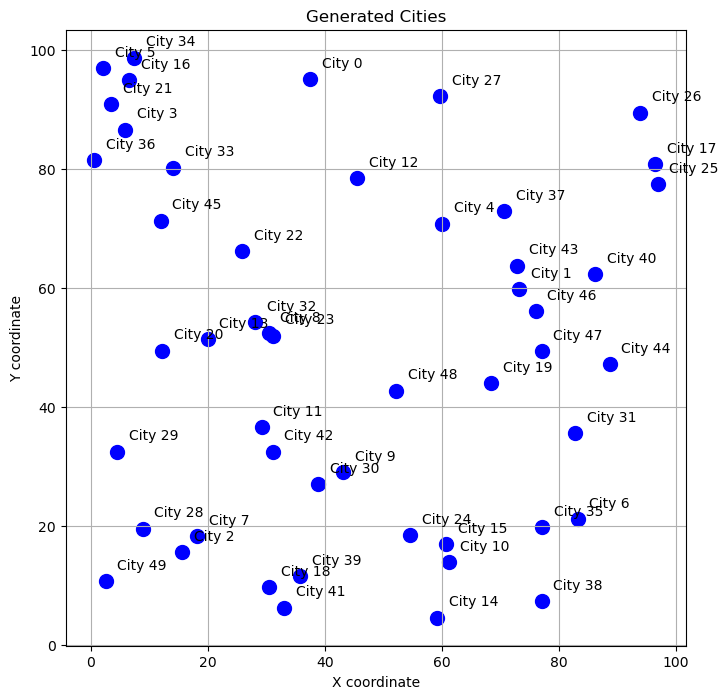

In [ ]:
# Plot the cities
plt.figure(figsize=(8, 8))
plt.scatter(city_coords[:, 0], city_coords[:, 1], c="blue", s=100, marker="o")

# Label each city
for i, (x, y) in enumerate(city_coords):
    plt.text(x + 2, y + 2, f"City {i}", fontsize=10)

plt.title("Generated Cities")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.show()

In [ ]:
best_solution

array([22, 12,  0, 34, 16,  5, 21,  3, 36, 33, 20, 13, 32,  8, 23, 11, 42,
        9, 48, 19,  1, 43, 37,  4, 27, 26, 17, 25, 40, 44, 46, 47, 31,  6,
       35, 38, 15, 10, 14, 24, 30, 39, 41, 18,  7,  2, 49, 28, 29, 45])